# Chapter 6: Learning Best Practices for Model Evaluation and Hyperparameter Tuning

In this chapter, we learn how to

- Obtain unbiased estimates of model performance
- Diagnose common problems of machine learning algorithms
- Fine-tune machine learning models
- Evaluate predictive models using difference performance metrics

## Loading the Breast Cancer Wisconsin Dataset

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data',
                header=None)

In [17]:
# assign features to a numpy array
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values

le = LabelEncoder()

y = le.fit_transform(y) # M = 1, B = 0

# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   stratify=y,
                                                   random_state=1)

## Combining Estimators in a Pipeline

Pipeline class in sklearn allows us to combine multiple transformation steps.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(solver='lbfgs',
                                          random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print ('Test Accuracy: %5f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956140


## Using k-fold Cross Validation to Assess Model Performance

Remember, a key step in machine learning is to estimate a model's performance on unseen data.

In k-fold cross validation, we split the data into k folds and use k-1 folds to train the model. The remaining fold is used for performance evaluation.

A good standard value of k is 10, as empirical evidence shows (e.g. Ron Kohavi). Smaller datasets may require more folds, and larger datasets may be okay with less folds (~5). In extreme cases, it is acceptable to use Leave-One-Out-Cross-Validation (LOOCV).

A slight improvement for classification problems can be made by stratifying each of the folds to ensure class proportions are representative.

In [22]:
# stratified k-fold cross validation
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10,
                       random_state=1).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print ('Fold: %2d, Class Dist.: %s Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))
    
print ('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class Dist.: [256 153] Acc: 0.935
Fold:  2, Class Dist.: [256 153] Acc: 0.935
Fold:  3, Class Dist.: [256 153] Acc: 0.957
Fold:  4, Class Dist.: [256 153] Acc: 0.957
Fold:  5, Class Dist.: [256 153] Acc: 0.935
Fold:  6, Class Dist.: [257 153] Acc: 0.956
Fold:  7, Class Dist.: [257 153] Acc: 0.978
Fold:  8, Class Dist.: [257 153] Acc: 0.933
Fold:  9, Class Dist.: [257 153] Acc: 0.956
Fold: 10, Class Dist.: [257 153] Acc: 0.956

CV accuracy: 0.950 +/- 0.014


In [24]:
# we can also use scikit learns build in cross validation 
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe_lr,
                        X_train,
                        y_train,
                        cv=10,
                        n_jobs=2) # controls number of cores used

print ('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


CV accuracy: 0.950 +/- 0.014


## Debugging Algorithms With Learning and Validation Curves

### Learning Curves

Learning curves illustrate how bias and variance of a model change with the amount of data 'learned'.

**Biased Models** learning curves' will display both the training and validation accuracy far away from desired accuracy.

**High Variance Models** learning curves' will achieve a higher accuracy, but training and validation accuracy will not converge.

/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


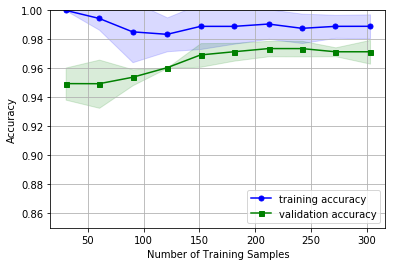

In [32]:
# visualizing the learning curve with scikit learn
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# fitting the learning curve
pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(solver='lbfgs',
                                          penalty='l2',
                                         random_state=1))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                             X=X_train,
                             y=y_train,
                             train_sizes=np.linspace(0.1,1.0,10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
               train_mean + train_std,
               train_mean - train_std,
               alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
        color='green', marker='s',
        markersize=5, label='validation accuracy')

plt.fill_between(train_sizes,
               test_mean + test_std,
               test_mean - test_std,
               alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.85,1.0])
plt.show()

### Addressing Over and Underfitting With Validation Curves

Instead of showing us how performance varies with training size, validation curves vary the values of model parameters.

Let's examine how performance varies with the inverse regularization parameter C in logistic regression.

/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/zach/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

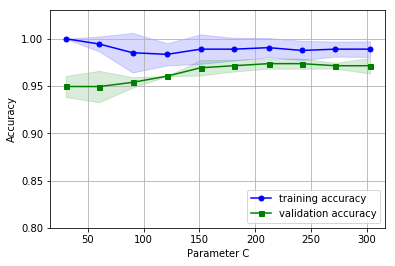

In [31]:
from sklearn.model_selection import validation_curve

param_range = [.001, .01, .1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                            X=X_train,
                                            y=y_train,
                                            param_name='logisticregression__C',
                                            param_range=param_range,
                                            cv=10)
plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
               train_mean + train_std,
               train_mean - train_std,
               alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
        color='green', marker='s',
        markersize=5, label='validation accuracy')

plt.fill_between(train_sizes,
               test_mean + test_std,
               test_mean - test_std,
               alpha=0.15, color='green')
plt.grid()
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8,1.03])
plt.show()

## Fine Tuning Machine Learning Models via Grid Search

Parameters of a learning algorithm, called hyperparameters, are optimized separately from parameters learned in training. Grid search helps us to find the optimal combination of hyperparameter values.

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                        SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1,
              1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C' : param_range,
              'svc__kernel' : ['linear']},
             {'svc__C' : param_range,
             'svc__gamma' : param_range,
             'svc__kernel' : ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print (gs.best_score_)
print (gs.best_params_)

0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


## Algorithm Selection With Nested Cross-Validation

If we want to select among different machine learning algorithms, nested cross-validation is the recommended approach.

In nested cross-validation, we have an outer k-fold cross validation loop to split the data into training and test folds, and an inner loop used to select the model using k-fold cross validation on the training data.

The example below uses 5x2 nested cross validation to compare a support vector classifier with a decision tree.

In [36]:
# nested validation with sklearn - an example of 5 by 2 cross validation - Support Vector Classifier
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=2)

scores = cross_val_score(gs,
                        X_train,
                        y_train,
                        scoring='accuracy',
                        cv=5)
print ('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [37]:
# nested validation with sklearn - an example of 5 by 2 cross validation - Decision Tree
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth' : [1, 2, 3, 4, 5, 6, 7, None]}],
                 scoring='accuracy',
                 cv=2)

scores = cross_val_score(gs,
                        X_train,
                        y_train,
                        scoring='accuracy',
                        cv=5)
print ('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.934 +/- 0.016


## Performance Evaluation Metrics

Up until now, we've been measuring our models using accuracy as the criteria. However, several other measures that may be worth exploring include

- precision
- recall
- F1-score

Before we start, let's look at a good summary of all measures - the confusion matrix.

In [38]:
# calculating and plotting confusion matrix
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print (confmat)

[[71  1]
 [ 2 40]]


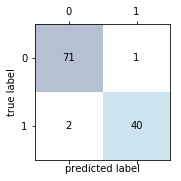

In [39]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
               s=confmat[i, j],
               va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

**Precision** is the percent of correct predictions for a predicted class

**Recall** is the number of correct predictions for a *true* class

**F1 Score** is a combination of precision and recall

In [42]:
# precision, recall, and f1 score in scikitlearn

from sklearn.metrics import precision_score, recall_score, f1_score

print ('Precision %.3f' % (precision_score(y_test, y_pred)))
print ('Recall %.3f' % (recall_score(y_test, y_pred)))
print ('F1 %.3f' % (f1_score(y_test, y_pred)))

Precision 0.976
Recall 0.952
F1 0.964


In [44]:
# we can also specify a different scoring metric in our grid search optimizaiton
from sklearn.metrics import f1_score, make_scorer
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=10)
gs = gs.fit(X_train, y_train)
print (gs.best_score_)
print (gs.best_params_)

0.9880219137963148
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


## Plotting A Receiver Operating Characteristic

The diagonal curve of an ROC graph can be interpreted as random guessing. Anything falling below this line is interpreted as *worse than random guessing*.

The **ROC Area Under the Curve (ROC AUC)** is computed to characterize the performance of a model.

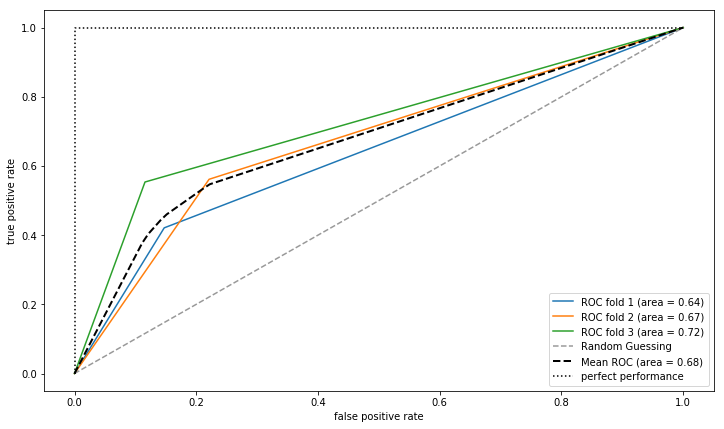

In [52]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(solver='lbfgs',
                                         penalty='l2',
                                         random_state=1,
                                         C=100.0))

X_train2 = X_train[:, [4,14]]

cv = list(StratifiedKFold(n_splits=3,
                         random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(12,7))

mean_tpr = 0
mean_fpr = np.linspace(0,1,100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                    probas,#[:,1],
                                    pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
            tpr,
            label='ROC fold %d (area = %.2f)'
            % (i+1, roc_auc))
plt.plot([0,1],
        [0,1],
        linestyle='--',
        color=(.6,.6,.6),
        label='Random Guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,
        mean_tpr,
        'k--',
        label='Mean ROC (area = %.2f)' % (mean_auc), lw=2)
plt.plot([0, 0, 1],
        [0, 1, 1],
        linestyle=':',
        color='black',
        label='perfect performance')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')
plt.show()

## Scoring Metrics for Multi-Class Classification

We can extend standard binary scoring metrics to multiple classes using various averaging methods.

**Micro-average** is calculated from the individual confusion matrix values of each class. 

- Useful if we want to weight each *prediction* equally

**Macro-average** is calculated by weighing all individual class statistics equally and averaging them.

- Useful when we want to weight scoring for each class equally

## Dealing With Class Imbalance

Class imbalance may impact how we evaluate performance metrics for our model.

Class imbalance also influences the learning algorithm during model fitting. Since most algorithms minimize a cost function, they tend to be biased towards the majority class. Techniques for dealing with this include

- Modifying penalties associated with each class during learning
- Upsampling the minority class/downsampling the majority class to generate synthetic training samples

The imbalance-learn library has good choices for dealing with class imbalance including Synthetic Minority Oversampling Technique (SMOTE).